# Application of Loops - Simulations

One major application of loops is running simulations. Our first example of this will be creating an efficient frontier through simulation.

In [1]:
# Import the required modules
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import seaborn as sns
%matplotlib inline

In [2]:
# We will also set a seed to use throughout the notebook. This will be used in our simulation.
rng = np.random.default_rng(seed = 1000)

In [3]:
# We will now get data for a few stocks using yfinance.

stock_list = ['AAPL', 'NKE', 'GOOGL', 'AMZN']

df = yf.download(stock_list, start = "2010-01-01", end = "2023-12-31")
df

[*********************100%***********************]  4 of 4 completed


Price                       Adj Close                                      \
Ticker                           AAPL        AMZN       GOOGL         NKE   
Date                                                                        
2010-01-04 00:00:00+00:00    6.454504    6.695000   15.666453   13.708184   
2010-01-05 00:00:00+00:00    6.465665    6.734500   15.597464   13.762726   
2010-01-06 00:00:00+00:00    6.362820    6.612500   15.204272   13.678817   
2010-01-07 00:00:00+00:00    6.351057    6.500000   14.850323   13.813066   
2010-01-08 00:00:00+00:00    6.393281    6.676000   15.048295   13.785798   
...                               ...         ...         ...         ...   
2023-12-22 00:00:00+00:00  192.868149  153.419998  141.327805  107.236305   
2023-12-26 00:00:00+00:00  192.320206  153.410004  141.357773  107.216446   
2023-12-27 00:00:00+00:00  192.419830  153.339996  140.209076  106.333069   
2023-12-28 00:00:00+00:00  192.848206  153.380005  140.069244  108.010506   
2023-12-29 00:00:00+00:00  191.802170  151.940002  139.529861  107.762367   

Price                           Close                                      \
Ticker                           AAPL        AMZN       GOOGL         NKE   
Date                                                                        
2010-01-04 00:00:00+00:00    7.643214    6.695000   15.684434   16.337500   
2010-01-05 00:00:00+00:00    7.656429    6.734500   15.615365   16.402500   
2010-01-06 00:00:00+00:00    7.534643    6.612500   15.221722   16.302500   
2010-01-07 00:00:00+00:00    7.520714    6.500000   14.867367   16.462500   
2010-01-08 00:00:00+00:00    7.570714    6.676000   15.065566   16.430000   
...                               ...         ...         ...         ...   
2023-12-22 00:00:00+00:00  193.600006  153.419998  141.490005  108.040001   
2023-12-26 00:00:00+00:00  193.050003  153.410004  141.520004  108.019997   
2023-12-27 00:00:00+00:00  193.149994  153.339996  140.369995  107.129997   
2023-12-28 00:00:00+00:00  193.580002  153.380005  140.229996  108.820000   
2023-12-29 00:00:00+00:00  192.529999  151.940002  139.690002  108.570000   

Price                            High              ...         Low  \
Ticker                           AAPL        AMZN  ...       GOOGL   
Date                                               ...               
2010-01-04 00:00:00+00:00    7.660714    6.830500  ...   15.621622   
2010-01-05 00:00:00+00:00    7.699643    6.774000  ...   15.554054   
2010-01-06 00:00:00+00:00    7.686786    6.736500  ...   15.174174   
2010-01-07 00:00:00+00:00    7.571429    6.616000  ...   14.831081   
2010-01-08 00:00:00+00:00    7.571429    6.684000  ...   14.742492   
...                               ...         ...  ...         ...   
2023-12-22 00:00:00+00:00  195.410004  154.350006  ...  140.710007   
2023-12-26 00:00:00+00:00  193.889999  153.979996  ...  141.190002   
2023-12-27 00:00:00+00:00  193.500000  154.779999  ...  139.889999   
2023-12-28 00:00:00+00:00  194.660004  154.080002  ...  139.750000   
2023-12-29 00:00:00+00:00  194.399994  153.889999  ...  138.779999   

Price                                        Open                          \
Ticker                            NKE        AAPL        AMZN       GOOGL   
Date                                                                        
2010-01-04 00:00:00+00:00   16.280001    7.622500    6.812500   15.689439   
2010-01-05 00:00:00+00:00   16.174999    7.664286    6.671500   15.695195   
2010-01-06 00:00:00+00:00   16.235001    7.656429    6.730000   15.662162   
2010-01-07 00:00:00+00:00   16.262501    7.562500    6.600500   15.250250   
2010-01-08 00:00:00+00:00   16.235001    7.510714    6.528000   14.814815   
...                               ...         ...         ...         ...   
2023-12-22 00:00:00+00:00  107.449997  195.179993  153.770004  140.770004   
2023-12-26 00:00:00+00:00  107.480003  193.610001  153.559998  141.589996   
2023-12-27 00:

In [4]:
# We now calculate the annual returns for each stock, based on the adjusted close. We will utilise Pandas to do this.

df2 = df['Adj Close']

stock_daily = df2.pct_change()
stock_er = stock_daily.mean() * 252 #252 is used as there are on average 252 trading days in a year.

In [5]:
# Compute covariances
cov_daily = stock_daily.cov()
cov_annual = cov_daily * 252

In [9]:
# Now we create empty lists to store our simulation results
port_returns = []
port_volatility = []
sharpe_ratio = []
stock_weights = []

In [10]:
# We create the parameters required for our loop
num_stocks = len(stock_list)
num_portfolios = 250_000
rf = 0.05 # risk-free rate

In [11]:
# We now create a for loop, which generates random weights and uses these weights to calculate portfolio return & variance
# Dot products are calculated using np.dot()

for _ in range(num_portfolios):
    weights = rng.uniform(0,1, num_stocks)                               # generate random weights, one weight for each stock
    weights /= np.sum(weights)                                           # normalise the weights, so they must add to one
    returns = np.dot(weights, stock_er)                                  # calculate the dot product of our weights and stock returns
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights))) # calculate portfolio volatility, with more matrix multiplication
    sharpe = (returns - rf) / volatility                                 #calculate the sharpe ratio 
    
    # Build out the lists with results for each iteration
    sharpe_ratio.append(sharpe)
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

In [12]:
# Create a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

# Now, extend the original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(stock_list):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

In [13]:
# Make a nice dataframe of the extended dictionary
frontier = pd.DataFrame(portfolio)

# Get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in stock_list]

# Reorder dataframe columns
frontier = frontier[column_order]

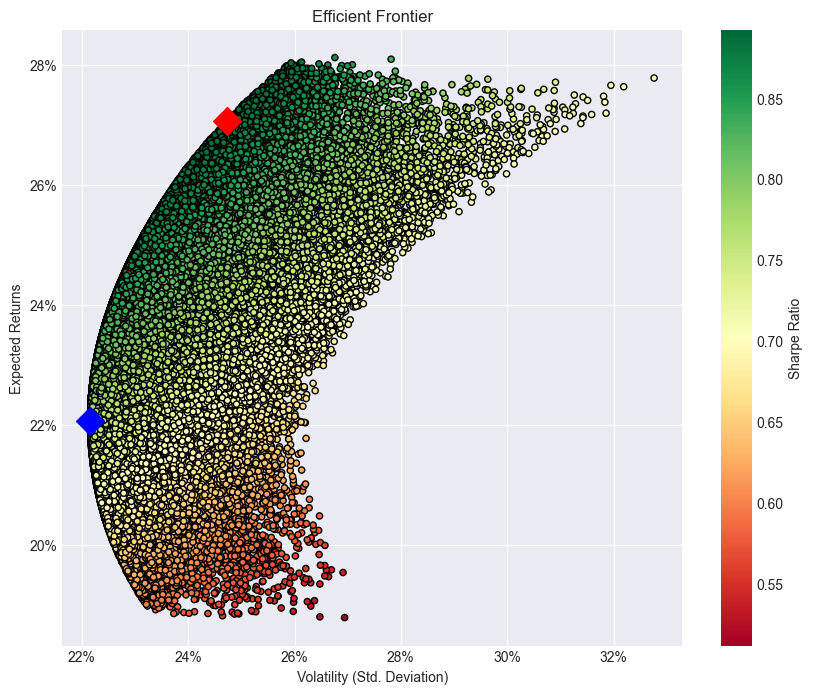

In [19]:
# We can now plot our efficient frontier, using MatPlotLib
import matplotlib.ticker as mtick
# Find min Volatility & max sharpe values in the dataframe (df)
min_volatility = frontier['Volatility'].min()
max_sharpe = frontier['Sharpe Ratio'].max()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = frontier.loc[frontier['Sharpe Ratio'] == max_sharpe]
min_variance_port = frontier.loc[frontier['Volatility'] == min_volatility]


# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-v0_8-darkgrid')
frontier.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)


plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=200)
plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='D', s=200 )

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))

plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')

plt.title('Efficient Frontier')
plt.show()

# Functions

We have just used a loop to run a simulation and create an efficient frontier. As a demonstration of functions, we will now add the above into a function.

In [22]:
def calculate_frontier(stock_list: list,
                       num_portfolios: int,
                       rf: float,
                       start_date: str,
                       end_date: str,
                       long_only: bool):
    """
    Calculates the efficient frontier for a given list of stocks.

    Args:
        stock_list (list): A list of stock symbols.
        num_portfolios (int): The number of portfolios to simulate.
        rf (float): The risk-free rate.
        start_date (str): The start date for the stock data.
        end_date (str): The end date for the stock data.

    Returns:
        None
    """
    print('-'*80)
    print('Downloading stock data')
    data = yf.download(stock_list, start = start_date, end = end_date)

    print('-'*80)
    print('Calculating portfolios')
    df = data['Adj Close']
    stock_daily = df.pct_change()
    stock_er = stock_daily.mean() * 252 
    cov_daily = stock_daily.cov()
    cov_annual = cov_daily * 252

    port_returns = []
    port_volatility = []
    sharpe_ratio = []
    stock_weights = []

    num_stocks = len(stock_list)

    for _ in range(num_portfolios):
        if long_only:
            weights = rng.uniform(0,1, num_stocks) #generate random weights, one weight for each stock LONG ONLY
        else:
            weights = rng.uniform(-1, 1, num_stocks) # long and short portfolio
        
        weights /= np.sum(weights) # Normalize the weights so that they sum to one

        returns = np.dot(weights, stock_er) #calculate the dot product of our weights and stock returns
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights))) #calculate portfolio volatility, with more matrix multiplication
        sharpe = (returns - rf) / volatility #calculate the sharpe ratio 
        sharpe_ratio.append(sharpe)
        port_returns.append(returns)
        port_volatility.append(volatility)
        stock_weights.append(weights)
    

    portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

    for i,symbol in enumerate(stock_list):
        portfolio[symbol+' Weight'] = [Weight[i] for Weight in stock_weights]

    frontier = pd.DataFrame(portfolio)
    column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in stock_list]
    frontier = frontier[column_order]

    if not long_only:
        frontier = frontier[frontier['Volatility'] < 0.4] # remove portfolios with volatility > 40% for short portfolios

    return frontier

def get_optimal_ps(frontier: pd.DataFrame):
    """
    Finds the optimal portfolios on the efficient frontier.

    Parameters:
        frontier (pd.DataFrame): A DataFrame containing the efficient frontier.

    Returns:
        A tuple containing two DataFrames: the portfolio with the maximum Sharpe ratio and the portfolio with the minimum variance.
    """
    min_volatility = frontier['Volatility'].min()
    max_sharpe = frontier['Sharpe Ratio'].max()

    sharpe_portfolio = frontier.loc[frontier['Sharpe Ratio'] == max_sharpe]
    min_variance_port = frontier.loc[frontier['Volatility'] == min_volatility]

    print('-'*80)
    print('Sharpe Maximised Portfolio:')
    display(sharpe_portfolio)
    print('-'*80)
    print('Minimum Variance Portfolio:')
    display(min_variance_port)

    return sharpe_portfolio, min_variance_port

def plot_frontier(frontier: pd.DataFrame, sharpe_portfolio: pd.DataFrame, min_variance_port: pd.DataFrame) -> None:
    """Plots the efficient frontier and marks the maximum sharpe and minimum variance portfolio.
    Args:
        frontier (pd.DataFrame): A DataFrame containing the efficient frontier.
        sharpe_portfolio (pd.DataFrame): A DataFrame containing the portfolio with the maximum Sharpe ratio.
        min_variance_port (pd.DataFrame): A DataFrame containing the portfolio with the minimum variance.

    Returns:
        None
    """
    plt.style.use('seaborn-v0_8-dark')
    # plt.style.use('seaborn-dark')
    frontier.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                    cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
    plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=100)
    plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='D', s=100)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
    plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
    plt.xlabel('Volatility (Std. Deviation)')
    plt.ylabel('Expected Returns')
    plt.title('Efficient Frontier')
    plt.show()


[*********************100%***********************]  5 of 5 completed

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Calculating portfolios


--------------------------------------------------------------------------------
Sharpe Maximised Portfolio:


,Returns,Volatility,Sharpe Ratio,AAPL Weight,NKE Weight,GOOGL Weight,AMZN Weight,TSLA Weight
20944,0.460334,0.290363,1.413178,0.108846,0.646443,0.004739,0.025238,0.214733


--------------------------------------------------------------------------------
Minimum Variance Portfolio:


,Returns,Volatility,Sharpe Ratio,AAPL Weight,NKE Weight,GOOGL Weight,AMZN Weight,TSLA Weight
114729,0.281353,0.224409,1.030945,0.148336,0.162763,0.281696,0.404355,0.00285


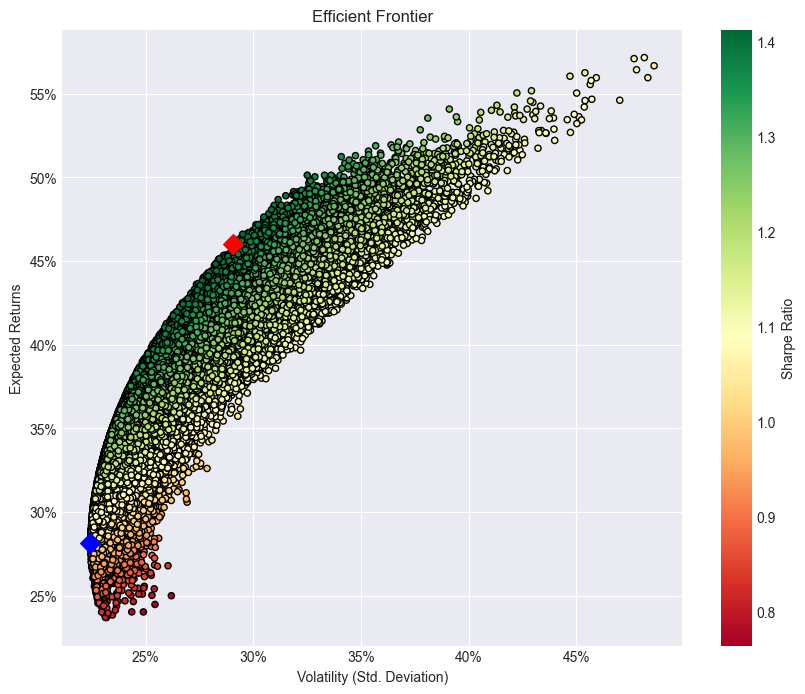

In [23]:
mc_p_l = calculate_frontier(stock_list= ['AAPL', 'NKE', 'GOOGL', 'AMZN', 'TSLA'],
                   num_portfolios = 200_000,
                   rf = 0.05,
                   start_date = "2015-01-01",
                   end_date = "2020-12-31",
                   long_only = True)

mc_sharpe_portfolio, mc_min_variance_port = get_optimal_ps(mc_p_l)

plot_frontier(mc_p_l, mc_sharpe_portfolio, mc_min_variance_port)

In [24]:
min_vol = mc_p_l.loc[mc_p_l['Volatility'] == mc_p_l['Volatility'].min()]
min_vol

,Returns,Volatility,Sharpe Ratio,AAPL Weight,NKE Weight,GOOGL Weight,AMZN Weight,TSLA Weight
114729,0.281353,0.224409,1.030945,0.148336,0.162763,0.281696,0.404355,0.00285


In [25]:
# Find the maximum return portfolio
max_return = mc_p_l.loc[mc_p_l['Returns'] == mc_p_l['Returns'].max()]
max_return

,Returns,Volatility,Sharpe Ratio,AAPL Weight,NKE Weight,GOOGL Weight,AMZN Weight,TSLA Weight
18883,0.571509,0.481588,1.082894,0.027227,0.075425,0.006532,0.04912,0.841696


# Analytical Solution

There is also an analytical solution, which can be derived through calculus.

First we define the following; <br>
<br>
$w=$ N-vector of weights <br>
$e=$ N-vector of expected returns <br>
$1=$ N-vector of ones <br>
$V=$ N $*$ N covariance matrix <br>
<br>
From the above, we calculate the below; <br>
<br>
$A = 1^T V^{-1}e$ <br>
$B = e^TV^{-1}e$ <br>
$C = 1^TV^{-1}1$<br>
$D=BC-A^2$ <br> 
<br>

We can calculate the weights to give a certain level of return with: <br>
<br>
$w_p = g + hE[r_p]$<br>
<br>
Where, <br>
<br>
$g = \frac{BV^{-1}1-AV^{-1}e}{D}$ <br>
$h = \frac{CV^{-1}e-AV^{-1}1}{D}$ <br>
<br>
From this result, we can find variance of the portfolio. <br>
<br>
$\sigma^2_p=\frac{CE[r_p]^2-2AE[r_p]+B}{D}$ <br>
<br>
We will now look to find the tangency portfolio. Again, we skip the derivation. <br>
<br>
$E[r_m] = \frac{Ar_f-B}{Cr_f-A}$ <br>
<br>
$\sigma_m = \frac{\sqrt{Cr^2_f-2Ar_f+B}}{|Cr_f-A|}$<br>
<br>
$w_m = g + h[\frac{Ar_f-B}{Cr_f-A}]$


In [26]:
# Lets use the above to find the tangency (maximum sharpe) portfolio for our stocks
# For simplicity, we will define the matrices as shown above

stock_list= ['AAPL', 'NKE', 'GOOGL', 'AMZN', 'TSLA']
df = yf.download(stock_list, start = "2015-01-01", end = "2020-12-31")['Adj Close']

e = (df.pct_change().mean() * 252).values.reshape(-1,1)
v = (df.pct_change().cov() * 252).values
one = np.ones(shape = [len(stock_list),1])
rf = 0.05

[*********************100%***********************]  5 of 5 completed


In [27]:
A = np.dot(one.T,np.dot(np.linalg.inv(v),e)).item()
B = np.dot(e.T,np.dot(np.linalg.inv(v),e)).item()
C = np.dot(one.T,np.dot(np.linalg.inv(v),one)).item()
D = B * C - A**2

g = (B * np.dot(np.linalg.inv(v),one) - A * np.dot(np.linalg.inv(v),e)) / D
h = (C * np.dot(np.linalg.inv(v),e) - A * np.dot(np.linalg.inv(v),one)) / D

In [28]:
# Now, we can apply the previous formulas for the tangency portfolio.

analytical_return = (A * rf - B) / (C*rf - A)
analytical_vol = ((C * rf**2 -2 * A * rf + B)**0.5)/(abs(C * rf - A))
analytical_weights = g + h * analytical_return
analytical_sharpe = (analytical_return - rf)/analytical_vol

# print(analytical_return, analytical_vol, analytical_weights, analytical_sharpe)

analytical_dict = {'Returns': analytical_return,
                   'Volatility': analytical_vol,
                   'Sharpe Ratio': analytical_sharpe}

# Add the weights for each stock to the dictionary
for i, stock in enumerate(stock_list):
    analytical_dict[stock + ' Weight'] = analytical_weights[i]

# Create a new DataFrame from the dictionary
analytical_df = pd.DataFrame(analytical_dict, index= [0])

# Print the DataFrame
display(analytical_df)

,Returns,Volatility,Sharpe Ratio,AAPL Weight,NKE Weight,GOOGL Weight,AMZN Weight,TSLA Weight
0,0.525816,0.324099,1.468118,0.219219,0.84396,-0.472635,0.156123,0.253333


## Compare to Monte Carlo Solution

In [29]:
mc_p_l_maximum_sharpe, mc_p_l_min_variance = get_optimal_ps(mc_p_l)

--------------------------------------------------------------------------------
Sharpe Maximised Portfolio:


,Returns,Volatility,Sharpe Ratio,AAPL Weight,NKE Weight,GOOGL Weight,AMZN Weight,TSLA Weight
20944,0.460334,0.290363,1.413178,0.108846,0.646443,0.004739,0.025238,0.214733


--------------------------------------------------------------------------------
Minimum Variance Portfolio:


,Returns,Volatility,Sharpe Ratio,AAPL Weight,NKE Weight,GOOGL Weight,AMZN Weight,TSLA Weight
114729,0.281353,0.224409,1.030945,0.148336,0.162763,0.281696,0.404355,0.00285


In [30]:
mc_sharpe = mc_p_l_maximum_sharpe['Sharpe Ratio'].values[0]

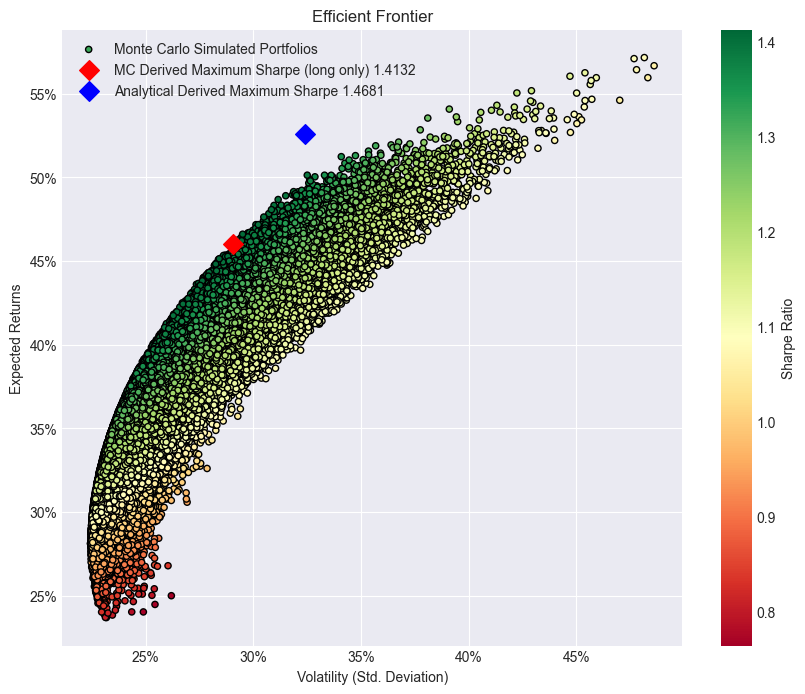

In [31]:
mc_p_l.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.scatter(x=mc_p_l_maximum_sharpe['Volatility'], y=mc_p_l_maximum_sharpe['Returns'], c='red', marker='D', s=100)

plt.scatter(x=analytical_vol, y=analytical_return, c='blue', marker='D', s=100)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
plt.legend(['Monte Carlo Simulated Portfolios', f'MC Derived Maximum Sharpe (long only) {mc_sharpe:.4f}', f'Analytical Derived Maximum Sharpe {analytical_sharpe:.4f}'])
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

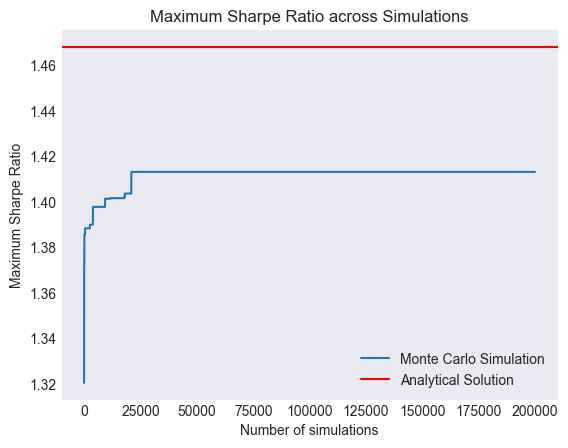

In [35]:
# Show how an increase in n gets closer to the analytical solution

mc_p2 = mc_p_l.copy().reset_index(drop=True)

# # Calculate the maximum Sharpe ratio for each simulation
max_sharpe_ratios = mc_p2['Sharpe Ratio'].cummax()[10:] # go 10 in to avoid the initial spike

# Plot the maximum Sharpe ratio
plt.plot(max_sharpe_ratios)                                # Monte Carlo simulation
plt.axhline(y=analytical_sharpe, color='r', linestyle='-') # Analytical solution

plt.title('Maximum Sharpe Ratio across Simulations')
plt.xlabel('Number of simulations')
plt.ylabel('Maximum Sharpe Ratio')
plt.legend(['Monte Carlo Simulation', 'Analytical Solution'])

plt.show()

In [36]:
# Now we allow for short portfolios
mc_p_s = calculate_frontier(stock_list= ['AAPL', 'NKE', 'GOOGL', 'AMZN', 'TSLA'],
                   num_portfolios = 200_000,
                   rf = 0.05,
                   start_date = "2015-01-01",
                   end_date = "2020-12-31",
                   long_only = False)

mc_p_s_maximum_sharpe, mc_p_s_min_variance = get_optimal_ps(mc_p_s)
mc_p_s_sharpe = mc_p_s_maximum_sharpe['Sharpe Ratio'].values[0]

[*********************100%***********************]  5 of 5 completed

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Calculating portfolios


--------------------------------------------------------------------------------
Sharpe Maximised Portfolio:


,Returns,Volatility,Sharpe Ratio,AAPL Weight,NKE Weight,GOOGL Weight,AMZN Weight,TSLA Weight
185597,0.515974,0.317987,1.465387,0.184589,0.784013,-0.376157,0.139037,0.268519


--------------------------------------------------------------------------------
Minimum Variance Portfolio:


,Returns,Volatility,Sharpe Ratio,AAPL Weight,NKE Weight,GOOGL Weight,AMZN Weight,TSLA Weight
170860,0.276624,0.224457,1.009657,0.145405,0.176492,0.273534,0.420899,-0.01633


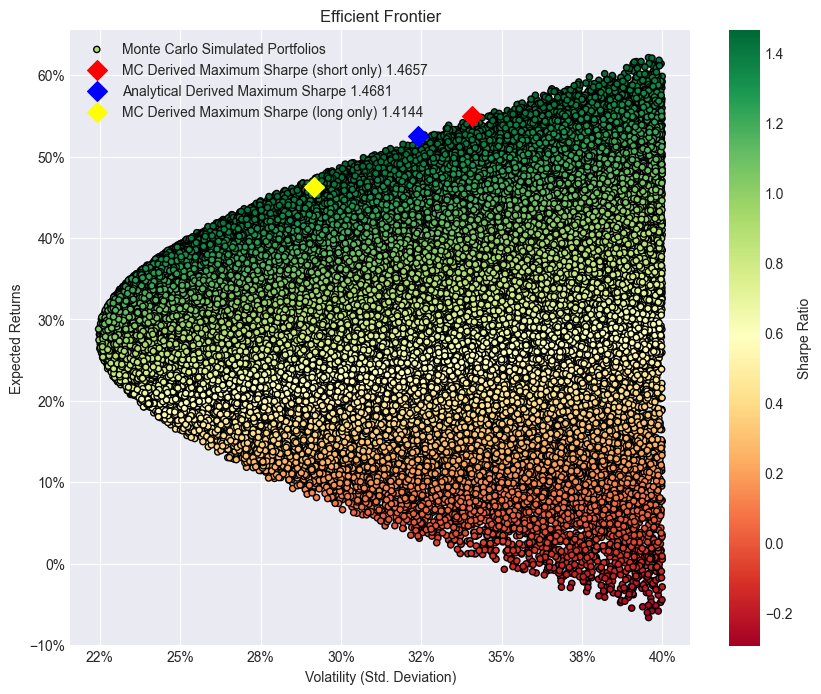

In [105]:
mc_p_s.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.scatter(x=mc_p_s_maximum_sharpe['Volatility'], y=mc_p_s_maximum_sharpe['Returns'], c='red', marker='D', s=100)



plt.scatter(x=analytical_vol, y=analytical_return, c='blue', marker='D', s=100)


# Long only best portfolio
plt.scatter(x=mc_p_l_maximum_sharpe['Volatility'], y=mc_p_l_maximum_sharpe['Returns'], c='yellow', marker='D', s=100)


plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
plt.legend(['Monte Carlo Simulated Portfolios', f'MC Derived Maximum Sharpe (short only) {mc_p_s_sharpe:.4f}', f'Analytical Derived Maximum Sharpe {analytical_sharpe:.4f}', f'MC Derived Maximum Sharpe (long only) {mc_sharpe:.4f}'])
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

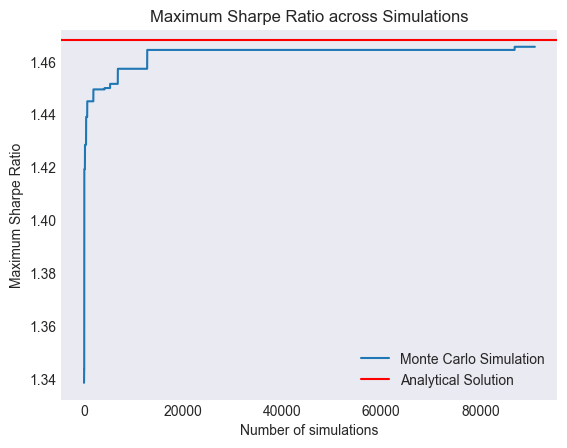

In [106]:
# Show how an increase in n gets closer to the analytical solution

mc_p3 = mc_p_s.copy().reset_index(drop=True)

# # Calculate the maximum Sharpe ratio for each simulation
max_sharpe_ratios = mc_p3['Sharpe Ratio'].cummax()[10:] # go 10 in to avoid the initial spike

# Plot the maximum Sharpe ratio
plt.plot(max_sharpe_ratios)                                # Monte Carlo simulation
plt.axhline(y=analytical_sharpe, color='r', linestyle='-') # Analytical solution

plt.title('Maximum Sharpe Ratio across Simulations')
plt.xlabel('Number of simulations')
plt.ylabel('Maximum Sharpe Ratio')
plt.legend(['Monte Carlo Simulation', 'Analytical Solution'])

plt.show()

# Optimisation Functions

Another method to calculate the efficient frontier is to use optimisation functions. We will perform these calculations to compare them with the simulated solution.

In [107]:
# First we need to gather our data and calculate returns, variance, and covariance

stock_list= ['AAPL', 'NKE', 'GOOGL', 'AMZN', 'TSLA']
df = yf.download(stock_list, start = "2015-01-01", end = "2020-12-31")
df2 = df['Adj Close']

ret_annual = df2.pct_change().mean() * 252
cov_annual = df2.pct_change().cov() * 252

[*********************100%%**********************]  5 of 5 completed


In [109]:
# In order to utilise optimisation packages, we need to define some functions.
# First we define a function which calculates portfolio return and variance given the returns and covariance matrices

def portfolio_stats(weights: np.ndarray,
                    returns: pd.DataFrame,
                    covs: pd.DataFrame) -> tuple:
    """
    Calculates the expected return and standard deviation of a portfolio.

    Parameters:
        weights (np.ndarray): The weights of the assets in the portfolio.
        returns (pd.DataFrame): The expected returns of the assets.
        covs (pd.DataFrame): The covariance matrix of the assets.

    Returns:
        tuple: A tuple containing the expected return and standard deviation of the portfolio.
    """
    port_return = np.dot(weights.reshape(1,-1), returns.values.reshape(-1,1))
    port_variance = np.dot(weights.reshape(1,-1), np.dot(covs.values, weights.reshape(-1,1)))
    port_sd = np.sqrt(port_variance)

    return np.squeeze(port_return), np.squeeze(port_sd)

# Next we define a function which calculates the Sharpe ratio for a portfolio. We will calculate the negative of the sharpe ratio, to make the problem a minimisation problem.
# This is done as the package we use can only minimise.

def portfolio_sharpe(weights: np.ndarray, 
                     returns: pd.DataFrame, 
                     covs: pd.DataFrame,
                     risk_free: float) -> float:
    """
    Calculates the Sharpe ratio of a portfolio.

    Parameters:
        weights (np.ndarray): The weights of the assets in the portfolio.
        returns (pd.DataFrame): The expected returns of the assets.
        covs (pd.DataFrame): The covariance matrix of the assets.
        risk_free (float): The risk-free rate of return.

    Returns:
        float: The Sharpe ratio of the portfolio.
    """
    port_return, port_sd = portfolio_stats(weights = weights,
                                           returns = returns,
                                           covs = covs)
    sharpe = -(port_return - risk_free)/port_sd
    return sharpe

In [110]:
# Now we have created our objective functions, we can create an optimisation function, using SciPy.


def optimise_sharpe(returns,
                    covs,
                    risk_free,
                    w_bounds) -> tuple:
    """
    Optimizes the Sharpe ratio of a portfolio.

    Parameters::
        returns (np.ndarray): An array of historical returns for each asset in the portfolio.
        covs (np.ndarray): A covariance matrix of the returns.
        risk_free (float): The risk-free rate.
        w_bounds (tuple): A tuple of the lower and upper bounds for the weights of each asset.

    Returns:
        A tuple containing the maximum Sharpe ratio, the optimized weights, the expected return of the portfolio, and the volatility of the portfolio.
    """    
    init_guess = np.array([1/len(returns) for i in range(len(returns))]) # An initial guess for the algorithm, simply set to an equal weighted portfolio.
    args = (returns, covs, risk_free) # The arguments to be set by the function
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) # 'type': 'eq' sets an equality constraint. 'fun' sets a function, defined with lambda. The sum of weights (x), less 1, is 0.
    result = opt.minimize(fun=portfolio_sharpe, # The function to minimise
                          x0=init_guess, # Setting our initial guess
                          args=args, # Setting the arguments
                          method='SLSQP', # We use Sequential Least Squares Programing
                          bounds=tuple(w_bounds for j in range(len(returns))), # Create a bounds list for each asset
                          constraints=constraints, # Set the constraints
                          )
    if result['success']:
        print(result['message']) # This line returns a sucess message.
        opt_sharpe = - result['fun'] # Returns the minimum value, which we change the sign on to get the maximum sharpe
        opt_weights = result['x'] # Returns the optimised weights
        opt_return, opt_std = portfolio_stats(opt_weights, returns, covs) # Calculate volatility and portfolio returns
        return opt_sharpe, opt_weights, opt_return.item(), opt_std.item()
    else:
        print("Optimization operation was not succesful!")
        print(result['message'])
        return None

In [112]:
opt_sharpe, opt_weights, opt_return, opt_vol = optimise_sharpe(returns = ret_annual,
                                                                covs = cov_annual,
                                                                risk_free = 0.05,
                                                                w_bounds = (-1,1))

print(opt_sharpe, opt_weights, opt_return, opt_vol)


Optimization terminated successfully
1.4681180252610242 [ 0.21939197  0.84365211 -0.47257614  0.15635147  0.25318059] 0.525708523712784 0.3240260766011679


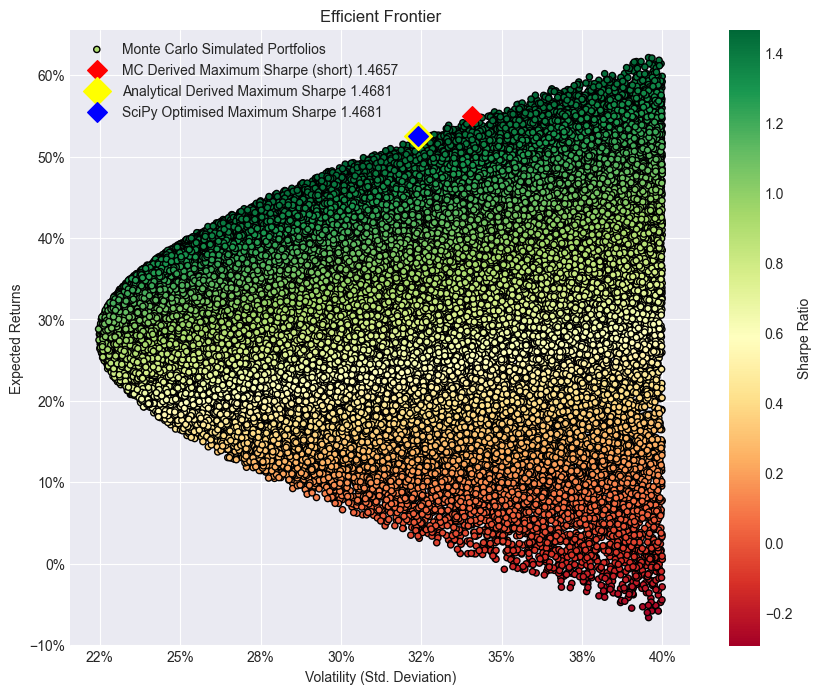

In [113]:
mc_p_s.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
plt.scatter(x=mc_p_s_maximum_sharpe['Volatility'], y=mc_p_s_maximum_sharpe['Returns'], c='red', marker='D', s=100)

mc_p_s_maximum_sharpe, mc_p_s_min_variance

plt.scatter(x=opt_vol, y=opt_return, c='yellow', marker='D', s=200)

plt.scatter(x=analytical_vol, y=analytical_return, c='blue', marker='D', s=100)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
plt.legend(['Monte Carlo Simulated Portfolios', f'MC Derived Maximum Sharpe (short) {mc_p_s_sharpe:.4f}', f'Analytical Derived Maximum Sharpe {analytical_sharpe:.4f}', f'SciPy Optimised Maximum Sharpe {opt_sharpe:.4f}'])
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

# Archive additional functions

In [ ]:
def portfolio_variance(weights: np.ndarray, 
                     returns: pd.DataFrame, 
                     covs: pd.DataFrame,
                     x
                     ) -> float:
    """
    Calculates the variance of a portfolio.

    Parameters:
    weights (np.ndarray): The weights of the assets in the portfolio.
    returns (pd.DataFrame): The expected returns of the assets.
    covs (pd.DataFrame): The covariance matrix of the assets.
    risk_free (float): The risk-free rate of return.

    Returns:
    float: The variance of the portfolio.
    """
    port_return, port_sd = portfolio_stats(weights = weights,
                                           returns = returns,
                                           covs = covs)
    port_var = port_sd**2

    return port_var 

# We are required to have the same number of inputs for the objective & optimisation functions. Thus, we add another term, e_return to the above.

def portfolio_variance2(weights, 
                     returns, 
                     covs,
                     risk_free: float,
                     #e_return
                     ):
    port_return, port_sd = portfolio_stats(weights = weights,
                                           returns = returns,
                                           covs = covs)
    port_var = port_sd**2

    return port_var 


In [45]:
# Now lets create some code to return the minimum variance portfolio

def optimise_variance(returns,
                    covs,
                    risk_free,
                    w_bounds = (-1,1)):
    init_guess = np.array([1/len(returns) for i in range(len(returns))]) # An initial guess for the algorithm, simply set to an equal weighted portfolio.
    args = (returns, covs, risk_free) # The arguments to be set by the function
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) # 'type': 'eq' sets an equality constraint. 'fun' sets a function, defined with lambda. The sum of weights (x), less 1, is 0.
    result = opt.minimize(fun=portfolio_variance, # The function to minimise
                          x0=init_guess, # Setting our initial guess
                          args=args, # Setting the arguments
                          method='SLSQP', # We use Sequential Least Squares Programing
                          bounds=tuple(w_bounds for j in range(len(returns))), # Create a bounds list for each asset
                          constraints=constraints, # Set the constraints
                          )
    if result['success']:
        print(result['message']) # This line returns a sucess message.
        opt_variance = result['fun'] # Returns the minimum variance.
        opt_weights = result['x'] # Returns the optimised weights.
        opt_return, opt_std = portfolio_stats(opt_weights, returns, covs) # Calculate volatility and portfolio returns
        opt_sharpe = (opt_return - risk_free)/opt_std
        return opt_sharpe.item(), opt_variance, opt_weights, opt_return.item(), opt_std.item()
    else:
        print("Optimization operation was not succesfull!")
        print(result['message'])
        return None

In [46]:
# Finally, lets create a function which returns the optimal weights for a given return. In this case, we still want to minimise variance.

def optimise_for_return(returns,
                    covs,
                    risk_free,
                    e_return,
                    w_bounds = (-1,1)):
    init_guess = np.array([1/len(returns) for i in range(len(returns))]) # An initial guess for the algorithm, simply set to an equal weighted portfolio.
    args = (returns, covs, risk_free, e_return) # The arguments to be set by the function
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                   {'type': 'eq', 'fun': lambda x: np.squeeze(np.dot(x.reshape(1,-1), returns.values.reshape(-1,1))) - e_return}] # 'type': 'eq' sets an equality constraint. 'fun' sets a function, defined with lambda. The sum of weights (x), less 1, is 0.
    result = opt.minimize(fun=portfolio_variance2, # The function to minimise
                          x0=init_guess, # Setting our initial guess
                          args=args, # Setting the arguments
                          method='SLSQP', # We use Sequential Least Squares Programing
                          bounds=tuple(w_bounds for j in range(len(returns))), # Create a bounds list for each asset
                          constraints=constraints, # Set the constraints
                          )
    if result['success']:
        print(result['message']) # This line returns a sucess message.
        opt_variance = result['fun'] # Returns the minimum variance.
        opt_weights = result['x'] # Returns the optimised weights.
        opt_return, opt_std = portfolio_stats(opt_weights, returns, covs) # Calculate volatility and portfolio returns
        opt_sharpe = (opt_return - risk_free)/opt_std
        return opt_sharpe.item(), opt_variance, opt_weights, opt_return.item(), opt_std.item()
    else:
        print("Optimization operation was not succesfull!")
        print(result['message'])
        return None

In [47]:
# Now, let's compare the maximum sharpe & minimum variance portfolios.

opt_sharpe, opt_weights, opt_return, opt_vol = optimise_sharpe(returns = ret_annual,
                                                                covs = cov_annual,
                                                                risk_free = 0.05,
                                                                w_bounds = (-1,1))

print(opt_sharpe, opt_weights, opt_return, opt_vol)

# The maximum sharpe portfolio is very similar.

Optimization terminated successfully
1.4681180497705506 [ 0.21939191  0.84365197 -0.47257603  0.15635165  0.2531805 ] 0.5257084393681699 0.3240260137408688


In [48]:
opt_sharpe, opt_variance, opt_weights, opt_return, opt_vol = optimise_variance(returns = ret_annual,
                                                                                covs = cov_annual,
                                                                                risk_free = 0.05,
                                                                                w_bounds = (-1,1))

print(opt_sharpe, opt_weights, opt_return, opt_vol)

# The minimum variance portfolio is also very similar.

Optimization terminated successfully
1.0187001758119791 [ 0.15609629  0.16442787  0.28347907  0.40333745 -0.00734068] 0.27854135229881233 0.22434604187306442
